### Monday, May 8th, 2023

This code runs the main GDN program and initializes a model with stored weights.

In [1]:
import os, sys

In [2]:
sys.path = [
    '', 
    '/home/callistb/miniconda3/envs/gdn/lib/python38.zip', 
    '/home/callistb/miniconda3/envs/gdn/lib/python3.8', 
    '/home/callistb/miniconda3/envs/gdn/lib/python3.8/lib-dynload', 
    '/home/callistb/miniconda3/envs/gdn/lib/python3.8/site-packages'
]

In [3]:
os.chdir('/home/callistb/GDN')

In [4]:
from main import *

In [5]:
random_seed = 5

random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
os.environ['PYTHONHASHSEED'] = str(random_seed)


train_config = {
    'batch': 32,
    'epoch': 50,
    'slide_win': 5,
    'dim': 128,
    'slide_stride': 1,
    'comment': '',
    'seed': random_seed,
    'out_layer_num': 1,
    'out_layer_inter_dim': 128,
    'decay': 0,
    'val_ratio': 0.2,
    'topk': 30,
}

env_config={
    'save_path': 'wadi',
    'dataset': 'wadi',
    'report': 'val',
    'device': 'cuda',
    'load_model_path': 'pretrained/wadi/best_05|04-15:46:47.pt'
}


main = Main(train_config, env_config, debug=False)
main.run()

=========================** Result **============================

F1 score: 0.40275650842266464
precision: 0.8885135135135135
recall: 0.2603960396039604



In [6]:
main.model

GDN(
  (embedding): Embedding(127, 128)
  (bn_outlayer_in): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gnn_layers): ModuleList(
    (0): GNNLayer(
      (gnn): GraphLayer(5, 128, heads=1)
      (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (leaky_relu): LeakyReLU(negative_slope=0.01)
    )
  )
  (out_layer): OutLayer(
    (mlp): ModuleList(
      (0): Linear(in_features=128, out_features=1, bias=True)
    )
  )
  (dp): Dropout(p=0.2, inplace=False)
)

I dug around in the code and found that the edge indices and attention weights for a given example are stored in each `GNNLayer` as `edge_index_1` and `att_weight_1`. We can access them after running the model on an input. For example:

In [247]:
# grab a mini-batch from the validatation set
x, _, _, edge_index = next(iter(main.val_dataloader))

# just take the first example from the mini-batch
x = x[[0]].float().cuda()
ei_0 = edge_index[[i]].float().cuda()

# model inputs are a window of 5 sensor values and a set of fully-connected edges
# model outputs are the predicted sensor values
pred = main.model(x, ei_0)

# model stores edge indices and attention weights while processing an input
ei = main.model.gnn_layers[0].edge_index_1.detach().cpu()
att = main.model.gnn_layers[0].att_weight_1.detach().cpu().flatten().numpy()

Next we can use the edge indices and attention weights to visualize the graph:

In [248]:
# code adapted from here -- https://pytorch-geometric.readthedocs.io/en/latest/get_started/introduction.html

import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx
from torch_geometric.data import Data

def visualize_graph(G, node_color=None, edge_color=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(
        G, 
        pos=nx.spring_layout(G, seed=42),
        with_labels=False,
        arrows=False,
        node_color=node_color,
        edge_color=edge_color,
        node_size=1,
        alpha=0.5,
        edge_cmap=plt.cm.Greys
    )
    plt.show()

In [249]:
G = to_networkx(Data(pred, ei))

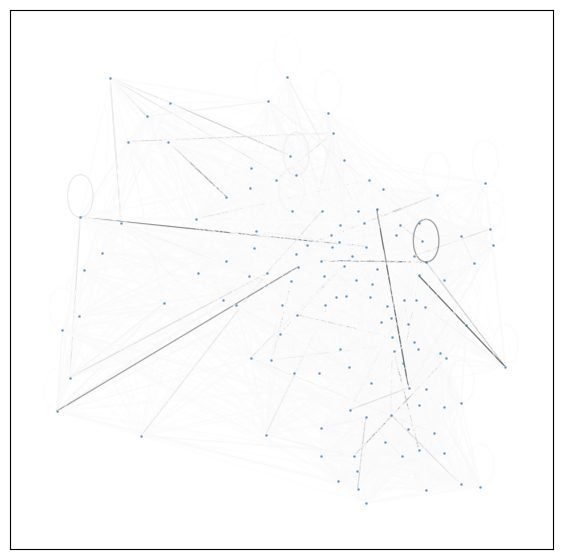

In [250]:
visualize_graph(G, edge_color=att)

Next I'll try to to use the model to find an attack in the test set and see if we can localize it with the graph like they do in the paper.